# Import

In [1]:
# General data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Utilities
import json
import os
import random
from collections import Counter

# Machine learning tools
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Distance computation
from scipy.spatial.distance import directed_hausdorff

# Google Cloud Storage client
from google.cloud import storage

# On one file

In [6]:
# Load the list of all known files
with open("all_files.json", 'r') as f :
    files = json.load(f)

In [7]:
# Extract all unique folder paths from degree files (files[1])
all_folders = sorted(list(set(path.rsplit('/', 1)[0] for path in files[1])))

folder = '' # Choose a folder manually or programmatically

# Get all files in the selected folder
folder_files = [file for file in files[1] if file.rsplit('/', 1)[0] == folder]

all_folders # Show all the folders
#[file.split('/')[-1] for file in folder_files] # Show all the files in the folder you chose

['gs://featurestore-spinewise/AnomalyDetectionBlacklist/gaia/blacklist',
 'gs://featurestore-spinewise/AnomalyDetectionBlacklist/gaia/whitelist',
 'gs://featurestore-spinewise/AnomalyDetectionBlacklist/penia/blacklist',
 'gs://featurestore-spinewise/AnomalyDetectionBlacklist/penia/whitelist',
 'gs://featurestore-spinewise/AnomalyDetectionScenarios/penia',
 'gs://featurestore-spinewise/Labelled_Data_with_walking_detection/krook2',
 'gs://featurestore-spinewise/Labelled_Data_with_walking_detection/sitting_detection_voskenslaan',
 'gs://featurestore-spinewise/anomaly_detection_manual_hedone/bad',
 'gs://featurestore-spinewise/anomaly_detection_manual_hedone/good',
 'gs://featurestore-spinewise/autocalibration_validation',
 'gs://featurestore-spinewise/bronze_to_silver_rerun/parquets/None/auxo3',
 'gs://featurestore-spinewise/bronze_to_silver_rerun/parquets/None/cora',
 'gs://featurestore-spinewise/bronze_to_silver_rerun/parquets/None/hedone',
 'gs://featurestore-spinewise/feature_stores/w

In [8]:
# Select a file index and load its content as a DataFrame
file_num = 57
file = files[1][file_num]
df = pd.read_parquet(file) # Replace 'file' with an explicit name to load a specific file

# Convert to numpy array
X = df.to_numpy()
print("X :",len(X)) # Total number of rows

X : 603224


⚠️ Avoid using DBSCAN on more than 100 000 points, instead use windowing to reduce the data ⚠️

In [9]:
window_size = 8 # Number of samples per window

# Aggregate features (mean alpha/beta per window)
features = []
for i in range(0, len(df) - window_size, window_size):
    window = df.iloc[i:i + window_size]
    feat = [window["alpha_angle"].mean(), window["beta_angle"].mean()]
    features.append(feat)

X = np.array(features)
print("X :",len(X)) # New reduced dataset

X : 75402


epsilon : 1.8545343474604747


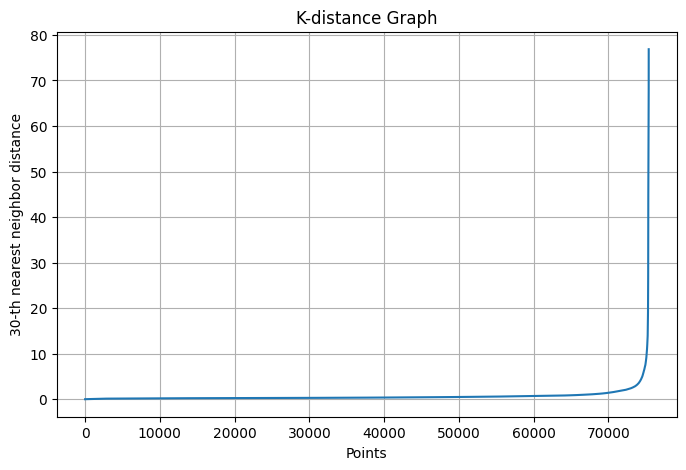

In [10]:
# Function to plot k-distance graph (visual tool to help choose an appropriate epsilon for DBSCAN)
def plot_k_distance_graph(X, k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    distances = np.sort(distances[:, k-1]) # k-th nearest neighbor distance
    plt.figure(figsize=(8, 5))
    plt.plot(distances)
    plt.grid()
    #plt.ylim(0,10)
    plt.xlabel('Points')
    plt.ylabel(f'{k}-th nearest neighbor distance')
    plt.title('K-distance Graph')
    plt.show()

# Estimate an appropriate epsilon value from the k-distance distribution
def estimate_epsilon_from_k_distance(X, k, percentile):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    k_distances = distances[:, k-1]
    epsilon = np.percentile(k_distances, percentile)
    return epsilon

# Estimate epsilon and visualize the k-distance graph
print("epsilon :",estimate_epsilon_from_k_distance(X, k=30, percentile=95))
plot_k_distance_graph(X, k=30)

Number of clusters: 8
Number of noise points: 2169


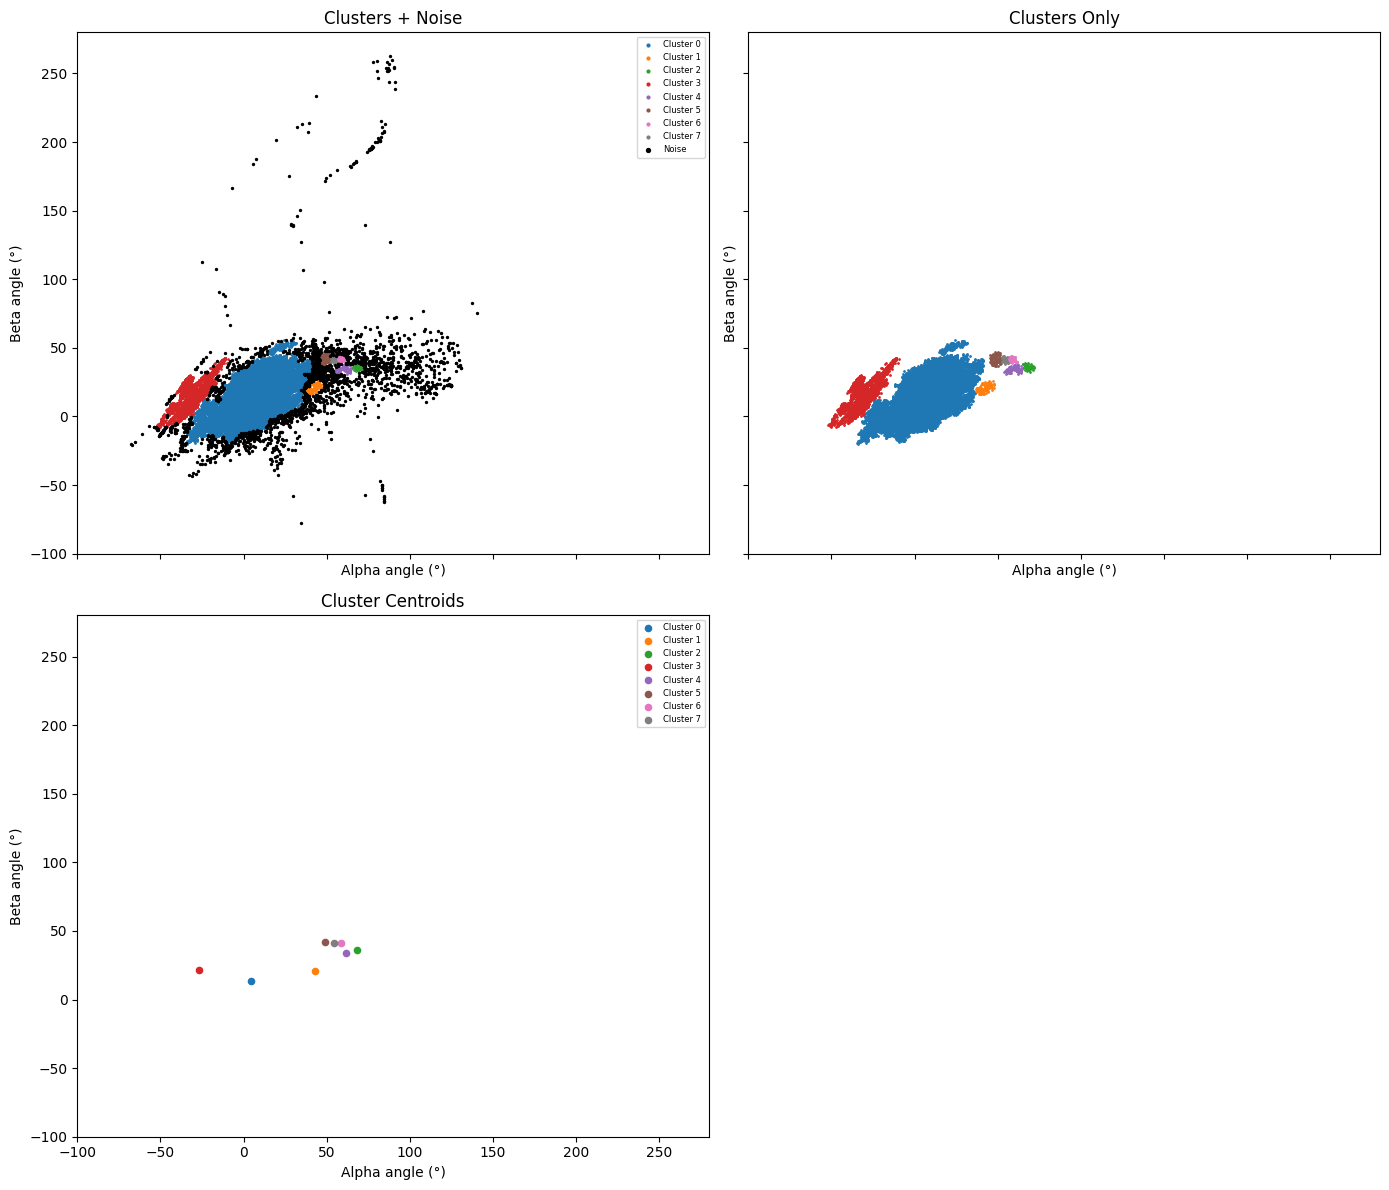

In [11]:
# DBSCAN parameters (use epsilon estimated or fixed)
epsilon = 2
min_samples = 30

# Perform DBSCAN clustering
db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(X)
labels = db.labels_

# Identify unique cluster labels (excluding noise, i.e., label == -1)
unique_labels = sorted(set(labels) - {-1})

# Color map : one consistent color per cluster label
cmap = plt.cm.tab10
label_to_color = {label: cmap(i % 10) for i, label in enumerate(unique_labels)}

# Compute centroids for each cluster
centroids = np.array([X[labels == label].mean(axis=0) for label in unique_labels])

# Count clusters and noise
n_clusters = len(unique_labels)
n_noise = list(labels).count(-1)
print('Number of clusters:', n_clusters)
print('Number of noise points:', n_noise)

# Separate cluster and noise points
core_points = X[labels != -1]
core_labels = labels[labels != -1]
noise_points = X[labels == -1]

# Set up the layout
fig, axs = plt.subplots(2, 2, figsize=(14, 12), sharex=True, sharey=True)
axs = axs.flatten()

# Plot 1: Clusters + Noise (with consistent color)
for label in unique_labels:
    points = X[labels == label]
    axs[0].scatter(points[:, 0], points[:, 1], color=label_to_color[label], s=1, label=f"Cluster {label}")
axs[0].scatter(noise_points[:, 0], noise_points[:, 1], color='black', s=2, label='Noise')
axs[0].set_title("Clusters + Noise")
axs[0].set_xlabel("Alpha angle (°)")
axs[0].set_ylabel("Beta angle (°)")
axs[0].set_xlim(-100, 280)
axs[0].set_ylim(-100, 280)
axs[0].legend(fontsize=6, markerscale=2)

# Plot 2: Clusters Only (same colors)
for label in unique_labels:
    points = X[labels == label]
    axs[1].scatter(points[:, 0], points[:, 1], color=label_to_color[label], s=1)
axs[1].set_title("Clusters Only")
axs[1].set_xlabel("Alpha angle (°)")
axs[1].set_ylabel("Beta angle (°)")
axs[1].set_xlim(-100, 280)
axs[1].set_ylim(-100, 280)

# Plot 3: Centroids with same colors
for label in unique_labels:
    centroid = X[labels == label].mean(axis=0)
    axs[2].scatter(centroid[0], centroid[1], color=label_to_color[label], s=20, label=f"Cluster {label}")
axs[2].set_title("Cluster Centroids")
axs[2].set_xlabel("Alpha angle (°)")
axs[2].set_ylabel("Beta angle (°)")
axs[2].set_xlim(-100, 280)
axs[2].set_ylim(-100, 280)
axs[2].legend(fontsize=6, markerscale=1)

# Hide the unused subplot
axs[3].axis("off")

plt.tight_layout()
plt.show()

# DBSCAN centroids, Hausdorff distance

### Centroids preparation

In [2]:
# Each row is a centroid => mean alpha and beta angle of a known good cluster (from gs://featurestore-spinewise/sensor_data_goldlist)
gold_centroids = np.array([[-1.02016167e+01,  4.99328324e+01],
       [-1.24108352e+01,  6.13043039e+01],
       [-8.19556953e+00,  6.60036607e+01],
       [-1.02974248e+00,  7.20354639e+01],
       [ 1.87195869e+00,  4.58127066e+01],
       [ 1.52749680e+01,  6.44750715e+01],
       [ 1.16029301e+01,  1.48637806e+01],
       [ 1.28035872e+01,  9.00977243e+01],
       [ 2.23461939e+01,  7.67915787e+01],
       [ 1.87194597e+01,  6.87231722e+01],
       [ 3.12296556e-01, -1.40305559e+01],
       [ 2.59760840e+01,  7.90530351e+01],
       [ 1.83306785e+01,  9.03629029e+01],
       [-1.79148744e+01,  1.83336318e+01],
       [ 3.02846275e+01,  4.20274539e+01],
       [-1.86832300e+01,  5.41431764e+01],
       [-2.22859195e+01,  4.91230785e+01],
       [ 4.05245396e+01,  4.37631882e+01],
       [ 2.41197047e+01,  5.39332362e+01],
       [ 5.12399071e+01,  4.40844012e+01],
       [-1.32887059e+01,  5.21157601e+00],
       [ 6.67633946e+01,  5.69710154e+01],
       [ 1.63003685e+01,  5.12456473e+01],
       [ 6.01230194e+01,  5.57146082e+01],
       [ 3.96388879e-01, -2.35296396e+01],
       [-7.59389042e+00, -2.93506869e+01],
       [ 1.23657326e+01, -1.28775968e+01],
       [ 2.19243955e+01,  5.58575354e+00],
       [-7.81804447e+00,  1.86068011e+01],
       [-1.49103768e+01, -5.67292666e+00],
       [-1.24559247e+01,  1.87458470e+01],
       [-1.11364323e+01,  2.58011235e+01],
       [ 2.61904627e+01,  1.33548628e+01],
       [ 7.92356718e+01,  3.70321169e+01],
       [ 4.18984522e+01,  4.76749477e+00],
       [ 1.56717068e+01, -1.58266950e+01],
       [ 3.75534941e+01,  2.62113821e+01],
       [ 5.74416910e+01,  6.54334308e+01],
       [ 5.26285707e+01,  5.37327337e+01],
       [ 5.49609036e+01,  6.04743508e+01],
       [-1.65421909e+01, -1.34007603e+01],
       [-3.57954816e+00,  9.20073648e+01],
       [-8.74901952e+00,  8.85352733e+01],
       [-3.40418376e+00,  8.65839470e+01],
       [-1.36069190e+01,  7.10941541e+01],
       [ 4.51632173e+01,  5.81615890e+01],
       [ 6.22440785e+01,  4.50817273e+01],
       [ 6.30005372e+01,  5.07270983e+01],
       [-3.04092282e+00,  5.57245136e+01],
       [ 2.66337590e-01,  7.78866559e+01],
       [-1.67611600e+01, -1.80428694e+01],
       [ 3.46498711e+01,  3.36745967e+01],
       [ 5.68482014e+01,  4.97923516e+01],
       [ 6.73344641e+01,  6.33929504e+01],
       [ 3.00499463e+01,  6.68015170e+01],
       [-1.60249992e+01, -2.77785233e+01],
       [ 4.04438354e+01,  5.96387599e+01],
       [ 6.41206764e+01,  6.76789715e+01],
       [ 3.16371986e+01,  5.78775965e+01],
       [ 8.95052675e+01,  6.25969754e+01],
       [ 3.81926103e+01,  7.01286093e+01],
       [-1.96213456e+01,  3.33344886e+01],
       [-8.73397785e+00,  4.22218253e+01],
       [-1.23375146e+01,  4.00006037e+01],
       [ 1.26116496e+01,  4.17697746e+01],
       [-8.71567637e+00,  9.04460392e+00],
       [-7.94610169e+00,  3.57318572e+01],
       [-2.44408592e+01,  8.34895010e-02],
       [-2.45466198e+00,  6.16795209e+01],
       [-2.04579958e+01,  4.19951001e+01],
       [ 4.43141335e+00,  5.75265377e+01],
       [-1.58884100e+01,  4.57039277e+01],
       [ 6.27448854e+01,  1.27309956e+01],
       [ 6.84105180e+01,  1.91739507e+01],
       [ 4.44540432e+01,  4.26875457e+01],
       [ 3.38300822e+01,  5.22463834e+01],
       [ 2.04072100e+01,  4.88201006e+01],
       [ 2.72366705e+01,  7.11570806e+01],
       [ 7.58908720e+00,  6.64636667e+01],
       [ 2.27421124e+01,  6.38395730e+01],
       [ 3.66063555e+01,  8.05475537e+01],
       [-3.22680179e+01, -6.26226256e+01],
       [-2.40918137e+01, -6.11109977e+01],
       [-1.25102824e+01, -4.36874305e+01],
       [-1.13038340e+01, -3.64666826e+01],
       [-2.22608042e+01, -3.48213394e+01]])

len(gold_centroids)

86

In [3]:
# Function to estimate a good epsilon (DBSCAN) using k-distance method
def estimate_epsilon_from_k_distance(X, k, percentile):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    k_distances = distances[:, k-1]
    epsilon = np.percentile(k_distances, percentile)
    return epsilon

In [4]:
# Load labeled segments CSV with manual labels
results_csv = "labeled_s.csv"
df_csv = pd.read_csv(results_csv)

# Get list of unique file paths from the CSV
filepaths = set([val["filepath"] for index, val in df_csv.iterrows()])

# Load all selected files, trim heads/tails, convert to numpy
X_tot = []
for file in filepaths : 
    df = pd.read_parquet(file)
    df = df.iloc[125:-7500]
    X_file = df[["alpha_angle", "beta_angle"]].to_numpy()
    X_tot.append(dict(filepath = file, data = X_file))

# Separate labels
black = df_csv[df_csv["label"] == "Black"]
grey = df_csv[df_csv["label"] == "Grey"]
white = df_csv[df_csv["label"] == "White"]

# Prepare training data and cluster info
data_train, label_train, clusters_info = [], [], []
nbw, nbb = 0, 0

for index, val in df_csv.iterrows():
    file = val["filepath"]
    start = val["start_index"]
    if val["label"] == "White" :
        nbw += 1
        lab = 0
    elif val["label"] == "Black" :
        nbb += 1
        lab = 1
    else:
        continue # Ignore if not black or white segments
    
    # Extract time window from loaded data
    X = [X["data"] for X in X_tot if X["filepath"] == file][0]
    X = X[val["start_index"]:val["end_index"]]
    label_train.append(lab)
    
    #epsilon = round(estimate_epsilon_from_k_distance(X,20,93),3)
    
    epsilon = 0.5 # Fixed for now, could use estimate_epsilon_from_k_distance
    if epsilon < 0.01 :
        continue
    
    # Run DBSCAN on the window
    db = DBSCAN(eps=0.5, min_samples=5).fit(X)
    labels = db.labels_
    print("Serie",index,"   eps :",epsilon,"  nb clusters :",len(set(labels))-1)
    
    # Compute centroids of clusters
    centroids = []
    for label in set(labels):
        if label == -1 :
            continue  # Skip noise
        points = X[labels == label]
        if len(points) > 0 :
            centroids.append(np.mean(points, axis=0))

    clusters_info.append({
        "serie": index,
        "centroids": np.array(centroids), 
        "label" : lab
    })

Y_all = np.array(label_train)
len(black), len(grey), len(white)

Serie 0    eps : 0.5   nb clusters : 96
Serie 1    eps : 0.5   nb clusters : 121
Serie 2    eps : 0.5   nb clusters : 75
Serie 3    eps : 0.5   nb clusters : 115
Serie 4    eps : 0.5   nb clusters : 65
Serie 5    eps : 0.5   nb clusters : 53
Serie 6    eps : 0.5   nb clusters : 21
Serie 7    eps : 0.5   nb clusters : 77
Serie 8    eps : 0.5   nb clusters : 31
Serie 9    eps : 0.5   nb clusters : 122
Serie 10    eps : 0.5   nb clusters : 78
Serie 11    eps : 0.5   nb clusters : 64
Serie 12    eps : 0.5   nb clusters : 43
Serie 13    eps : 0.5   nb clusters : 50
Serie 16    eps : 0.5   nb clusters : 80
Serie 17    eps : 0.5   nb clusters : 87
Serie 18    eps : 0.5   nb clusters : 38
Serie 20    eps : 0.5   nb clusters : 36
Serie 22    eps : 0.5   nb clusters : 64
Serie 27    eps : 0.5   nb clusters : 101
Serie 28    eps : 0.5   nb clusters : 21
Serie 29    eps : 0.5   nb clusters : 27
Serie 30    eps : 0.5   nb clusters : 28
Serie 31    eps : 0.5   nb clusters : 29
Serie 32    eps : 0.5 

(175, 124, 176)

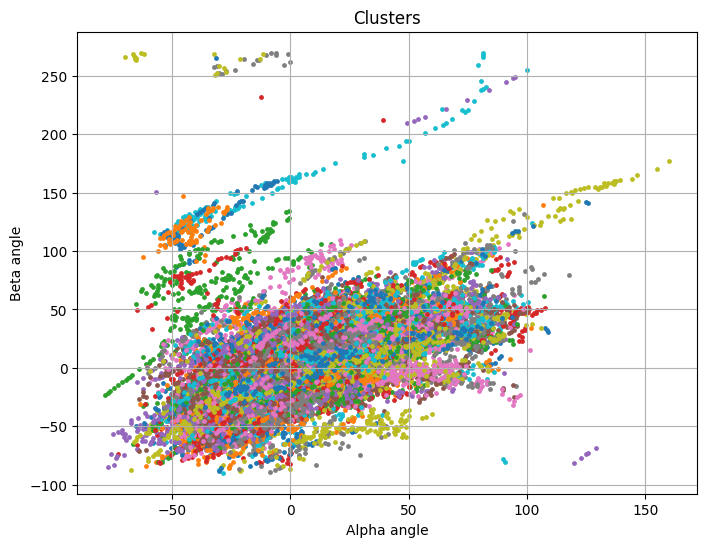

In [5]:
# Visualization of extracted centroids
plt.figure(figsize=(8, 6))
for cluster in clusters_info:
    centroids = cluster['centroids']
    centroids = list(zip(*centroids))
    plt.scatter(centroids[0], centroids[1], label=f"Série {cluster['serie']}", s=6)

plt.title("Clusters")
plt.xlabel("Alpha angle")
plt.ylabel("Beta angle")
#plt.legend()
plt.grid(True)
plt.show()

### Hausdorff dist to gold list centroids

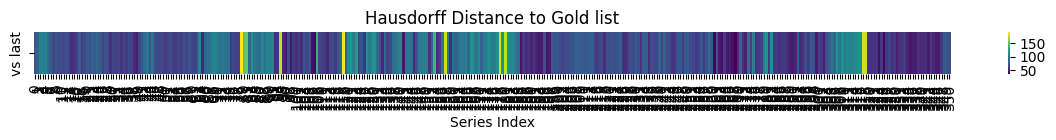

In [6]:
# Compute Hausdorff distance from each series' centroids to gold_centroids
series = [entry['centroids'] for entry in clusters_info]
n = len(series)
hausdorff_vector = np.zeros(n)

for i in range(n):
    A = series[i]
    B = np.array(gold_centroids)
    d1 = directed_hausdorff(A, B)[0]
    d2 = directed_hausdorff(B, A)[0]
    d = max(d1, d2)

    hausdorff_vector[i] = d
    
# Plot distance heatmap
plt.figure(figsize=(12, 1.5))
sns.heatmap([hausdorff_vector], cmap="viridis", xticklabels=True, yticklabels=["vs last"])
plt.title("Hausdorff Distance to Gold list")
plt.xlabel("Series Index")
plt.tight_layout()
plt.show()

In [7]:
X_all = np.array(hausdorff_vector).reshape(-1, 1)
X_all.shape, Y_all.shape

((351, 1), (351,))

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.4, random_state=None)

# Logistic regression on Hausdorff distances
log_model = LogisticRegression()
log_model.fit(X_train, Y_train)
log_pred = log_model.predict(X_test)

print("Accuracy:", round(accuracy_score(Y_test, log_pred), 4))
print("Classification Report:")
print(classification_report(Y_test, log_pred, target_names=["White", "Black"], zero_division=0))
print("Confusion Matrix:")
print(confusion_matrix(Y_test, log_pred))

Accuracy: 0.6809
Classification Report:
              precision    recall  f1-score   support

       White       0.60      0.84      0.70        62
       Black       0.81      0.56      0.66        79

    accuracy                           0.68       141
   macro avg       0.71      0.70      0.68       141
weighted avg       0.72      0.68      0.68       141

Confusion Matrix:
[[52 10]
 [35 44]]


In [9]:
# Monte Carlo simulation to assess logistic regression robustness
acc_rg = []
for i in range(1000) :
    X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.4, random_state=None)
    log_model = LogisticRegression()
    log_model.fit(X_train, Y_train)
    log_pred = log_model.predict(X_test)
    acc_rg.append(round(accuracy_score(Y_test, log_pred), 4))
    
np.mean(acc_rg), np.median(acc_rg)

(0.6955536, 0.695)

### Hausdorff dist to random segments

In [27]:
# Hausdorff distance to 10 random segments (5 white, 5 black)
series = [entry['centroids'] for entry in clusters_info]
n = len(series)
hausdorff_matrix = [[] for _ in range(n)]

# Indices of all white and black segments with non-empty centroid lists
white_indices = [i for i, entry in enumerate(clusters_info) if entry.get("label") == 0 and len(entry["centroids"]) > 0] 
black_indices = [i for i, entry in enumerate(clusters_info) if entry.get("label") == 1 and len(entry["centroids"]) > 0]

# Randomly select 5 white and 5 black segments as reference centroids
selected_white = random.sample(white_indices, 5)
selected_black = random.sample(black_indices, 5)

# Combine selected segment indices and extract corresponding centroid sets
selected_indices = selected_white + selected_black
random_seg = [clusters_info[i]["centroids"] for i in selected_indices]

#print(f"Shape du tableau white_centroids_array : {white_centroids_array.shape}")

for i in range(n) :
    B = series[i]
    for j in range(len(random_seg)):
        A = random_seg[j]
        d1 = directed_hausdorff(A, B)[0]
        d2 = directed_hausdorff(B, A)[0]
        hausdorff_matrix[i].append(max(d1, d2))

X_all = np.array(hausdorff_matrix)
X_all.shape, Y_all.shape

((351, 10), (351,))

In [28]:
# Train and evaluate an SVM classifier (RBF kernel) on Hausdorff-based features
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.4, random_state=None)

model = SVC(kernel='rbf', C=1.0)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

# Evaluate model
print("Accuracy:", round(accuracy_score(Y_test, Y_pred), 4))
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred, target_names=["White", "Black"], zero_division=0))
print("Confusion Matrix:")
print(confusion_matrix(Y_test, Y_pred))

Accuracy: 0.922

Classification Report:
              precision    recall  f1-score   support

       White       0.88      0.95      0.91        62
       Black       0.96      0.90      0.93        79

    accuracy                           0.92       141
   macro avg       0.92      0.93      0.92       141
weighted avg       0.92      0.92      0.92       141

Confusion Matrix:
[[59  3]
 [ 8 71]]


In [30]:
# Monte Carlo simulation to evaluate SVM classifier
acc_rl = []
for i in range(1000) :
    X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.4, random_state=None)
    lmodel = SVC(kernel='rbf', C=1.0)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    acc_rl.append(round(accuracy_score(Y_test, Y_pred), 4))
    
np.mean(acc_rl), np.median(acc_rl)

(0.9194759, 0.922)

# Centroids Hausdorff dist + parameters

### Data preparation

In [2]:
# Load CSV containing labeled segments (filepath, label, start_index, end_index)
df_csv = pd.read_csv("labeled_s2.csv")

# Extract unique file paths from the labeled CSV
filepaths = set(df_csv["filepath"])

# Load and preprocess each file: trim head and tail, extract alpha/beta columns
X_tot = []
for file in filepaths:
    df = pd.read_parquet(file)
    df = df.iloc[125:-7500]
    data = df[["alpha_angle", "beta_angle"]].to_numpy()
    X_tot.append(dict(filepath=file, data=data))

# Extract labeled segments for classification (White = 0, Black = 1)
X_data, label_data, index_data = [], [], []
for index, val in df_csv.iterrows():
    if val["label"] not in ["White", "Black"]:
        continue
    label = 0 if val["label"] == "White" else 1
    file = val["filepath"]
    segment = [x["data"] for x in X_tot if x["filepath"] == file][0]
    data = segment[val["start_index"]:val["end_index"]]
    X_data.append(data)
    index_data.append(index)
    label_data.append(label)

In [3]:
# DBSCAN-based centroid extraction
def extract_centroids_dbscan(data):
    clustering = DBSCAN(eps=0.5, min_samples=5).fit(data)
    labels = clustering.labels_
    centroids = []
    for label in set(labels):
        if label == -1:
            continue
        cluster_points = data[labels == label]
        centroid = cluster_points.mean(axis=0)
        centroids.append(centroid)
    return np.array(centroids)

# Fixed-window centroid extraction
def extract_centroids(data, window_size):
    return np.array([
        data[j:j + window_size].mean(axis=0)
        for j in range(0, len(data) - window_size, window_size)
    ])

# Feature extraction from centroid sets
def compute_features(centroids, refs):
    f = []
    f.extend(centroids.mean(axis=0))
    f.extend(centroids.std(axis=0))
    f.extend(centroids.min(axis=0))
    f.extend(centroids.max(axis=0))
    f.extend(np.median(centroids, axis=0))  
    f.append(len(centroids))
    for ref in refs:
        d1 = directed_hausdorff(centroids, ref)[0]
        d2 = directed_hausdorff(ref, centroids)[0]
        f.append(max(d1, d2)) # # Hausdorff distance to each reference
    return f

### dbscan centroids + parameters

In [39]:
clusters_info = []
for i, data in enumerate(X_data):
    centroids = extract_centroids_dbscan(data)
    if len(centroids) == 0:
        continue
    clusters_info.append(dict(index=i, centroids=centroids, label=label_data[i]))

# Select 10 reference series (5 White, 5 Black)
white_indices = [i for i, entry in enumerate(clusters_info) if entry.get("label") == 0 and len(entry["centroids"]) > 0]
black_indices = [i for i, entry in enumerate(clusters_info) if entry.get("label") == 1 and len(entry["centroids"]) > 0]

# Randomly select 5 white and 5 black segments as reference centroids
selected_white = random.sample(white_indices, 5)
selected_black = random.sample(black_indices, 5)

# Combine selected segment indices and extract corresponding centroid sets
selected_indices = selected_white + selected_black
ref_series = [clusters_info[i]["centroids"] for i in selected_indices]

# Extract feature matrix and labels
X_all = np.array([compute_features(entry["centroids"], ref_series) for entry in clusters_info])
Y_all = np.array([entry["label"] for entry in clusters_info])

# Standardize features
scaler = StandardScaler()
X_all = scaler.fit_transform(X_all)
X_all.shape, Y_all.shape

((351, 21), (351,))

In [43]:
# Train-test split and SVM training
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.4, random_state=None)
model = SVC(kernel='rbf', C=1.0)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

# Evaluate model
print("Accuracy:", round(accuracy_score(Y_test, Y_pred), 4))
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred, target_names=["White", "Black"], zero_division=0))
print("Confusion Matrix:")
print(confusion_matrix(Y_test, Y_pred))

Accuracy: 0.9645

Classification Report:
              precision    recall  f1-score   support

       White       0.96      0.97      0.96        70
       Black       0.97      0.96      0.96        71

    accuracy                           0.96       141
   macro avg       0.96      0.96      0.96       141
weighted avg       0.96      0.96      0.96       141

Confusion Matrix:
[[68  2]
 [ 3 68]]


In [41]:
# Monte Carlo simulation: DBSCAN feature stability
acc_db = []
for i in range(50) :
    X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.4, random_state=None)
    model = SVC(kernel='rbf', C=1.0)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    acc_db.append(round(accuracy_score(Y_test, Y_pred), 4))
    
np.mean(acc_db), np.median(acc_db)

(0.9734500000000001, 0.9716)

### Windows centroids + parameters

In [4]:
clusters_info = []
for i, data in enumerate(X_data) :
    centroids = extract_centroids(data, 100)
    if len(centroids) == 0:
        continue
    clusters_info.append(dict(index=i, centroids=centroids, label=label_data[i]))

# Select 10 reference series (5 White, 5 Black)
white_indices = [i for i, entry in enumerate(clusters_info) if entry.get("label") == 0 and len(entry["centroids"]) > 0]
black_indices = [i for i, entry in enumerate(clusters_info) if entry.get("label") == 1 and len(entry["centroids"]) > 0]

# Randomly select 5 white and 5 black segments as reference centroids
selected_white = random.sample(white_indices, 5)
selected_black = random.sample(black_indices, 5)

# Combine selected segment indices and extract corresponding centroid sets
selected_indices = selected_white + selected_black
ref_series = [clusters_info[i]["centroids"] for i in selected_indices]

# Extract feature matrix and labels
X_all = np.array([compute_features(c["centroids"], ref_series) for c in clusters_info])
Y_all = np.array([c["label"] for c in clusters_info])

# Standardize features
scaler = StandardScaler()
X_all = scaler.fit_transform(X_all)
X_all.shape, Y_all.shape

((1000, 21), (1000,))

In [5]:
# Train-test split and SVM training
X_train, X_test, Y_train, Y_test, idx_train, idx_test = train_test_split(X_all, Y_all, np.arange(len(X_all)), test_size=0.4, random_state=None)
model = SVC(kernel='rbf', C=1.0, probability=True)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

# Evaluate model
print("Accuracy:", round(accuracy_score(Y_test, Y_pred), 4))
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred, target_names=["White", "Black"], zero_division=0))
print("Confusion Matrix:")
print(confusion_matrix(Y_test, Y_pred))

Accuracy: 0.98

Classification Report:
              precision    recall  f1-score   support

       White       0.96      0.99      0.98       189
       Black       1.00      0.97      0.98       211

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400

Confusion Matrix:
[[188   1]
 [  7 204]]


In [6]:
# Monte Carlo simulation: windowed feature stability
acc_wi, fn, fp = [], [], []
for i in range(500) :
    X_train, X_test, Y_train, Y_test, idx_train, idx_test = train_test_split(X_all, Y_all, np.arange(len(X_all)), test_size=0.4, random_state=None)
    model = SVC(kernel='rbf', C=1.0)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    acc_wi.append(round(accuracy_score(Y_test, Y_pred), 4))
    
    fp_mask = (Y_test == 0) & (Y_pred == 1)
    fn_mask = (Y_test == 1) & (Y_pred == 0)
        
    fp.extend(idx_test[fp_mask])
    fn.extend(idx_test[fn_mask])
    
np.mean(acc_wi), np.median(acc_wi), Counter(fp), Counter(fn)

(0.9730800000000001,
 0.9725,
 Counter({429: 191, 985: 63, 380: 56, 339: 55, 369: 20, 381: 8, 398: 1}),
 Counter({628: 218,
          620: 210,
          619: 207,
          889: 204,
          601: 204,
          796: 201,
          838: 201,
          625: 201,
          577: 199,
          4: 198,
          543: 195,
          843: 191,
          810: 189,
          626: 187,
          574: 185,
          630: 180,
          92: 178,
          627: 175,
          554: 172,
          600: 162,
          634: 156,
          111: 151,
          621: 127,
          622: 121,
          841: 115,
          552: 111,
          553: 63,
          623: 56,
          839: 43,
          580: 38,
          635: 38,
          804: 32,
          560: 20,
          39: 12,
          617: 11,
          837: 10,
          612: 7,
          823: 6,
          824: 4,
          618: 4,
          1: 4,
          633: 1,
          825: 1,
          840: 1,
          594: 1}))

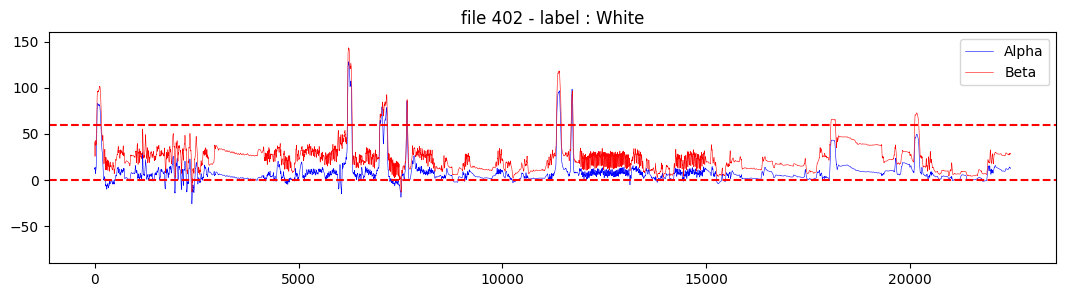

In [104]:
i = index_data[270]
file_infos = df_csv.loc[i]

df = pd.read_parquet(file_infos["filepath"])
df = df.iloc[125:-7500]

X = df[["alpha_angle", "beta_angle"]].to_numpy()
X = X[file_infos["start_index"]:file_infos["end_index"]]
label_x = file_infos["label"]

plt.figure(figsize=(13, 3))
plt.plot(X[:, 0], label='Alpha', color='blue', linewidth=0.4)
plt.plot(X[:, 1], label='Beta', color='red', linewidth=0.4)
plt.axhline(y=0.0, color='r', linestyle='--')
plt.axhline(y=60.0, color='r', linestyle='--')
plt.title(f"file {i} - label : {label_x}")
plt.ylim(-90, 160)
plt.legend()
plt.show()